<a href="https://colab.research.google.com/github/anly07/Data-Prediction-in-Colab/blob/main/Prediction_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

# Run this cell to upload your .xlsx file
uploaded = files.upload()

Saving 11Jun23 to 30Apr25.xlsx to 11Jun23 to 30Apr25.xlsx


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Read Excel file
df = pd.read_excel('11Jun23 to 30Apr25.xlsx', engine='openpyxl')

# Ensure datetime is parsed
df['date_time'] = pd.to_datetime(df['date_time'])
df = df.sort_values('date_time')
df.set_index('date_time', inplace=True)

# Add time features
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day


In [10]:
# Select top 5 important metrics
target_columns = ['active_energy', 'apparent_energy', 'pf', 'md', 'reactive_lead_energy',
    'reactive_lag_energy', 'min_active_power', 'max_active_power',
    'min_apparent_power', 'max_apparent_power', 'min_power_factor',
    'max_power_factor', 'avg_active_power', 'avg_apparent_power',
    'avg_power_factor', 'min_current_r', 'min_current_y', 'min_current_b',
    'max_current_r', 'max_current_y', 'max_current_b', 'avg_current_r',
    'avg_current_y', 'avg_current_b', 'min_volt_thd_r', 'min_volt_thd_y',
    'min_volt_thd_b', 'max_volt_thd_r', 'max_volt_thd_y', 'max_volt_thd_b',
    'avg_volt_thd_r', 'avg_volt_thd_y', 'avg_volt_thd_b', 'min_current_thd_r',
    'min_current_thd_y', 'min_current_thd_b', 'max_current_thd_r',
    'max_current_thd_y', 'max_current_thd_b', 'avg_current_thd_r',
    'avg_current_thd_y', 'avg_current_thd_b', 'min_volt_ry', 'min_volt_yb',
    'min_volt_rb', 'max_volt_ry', 'max_volt_yb', 'max_volt_rb', 'avg_volt_ry',
    'avg_volt_yb', 'avg_volt_rb', 'initial_apparent_energy', 'last_apparent_energy',
    'initial_active_energy', 'last_active_energy']

# Store results
results = {}
scores = {}

for target in target_columns:
    # Lag features
    df[f'{target}_lag1'] = df[target].shift(1)
    df[f'{target}_lag2'] = df[target].shift(2)

    temp_df = df[[target, 'year', 'month', 'day', f'{target}_lag1', f'{target}_lag2']].dropna()

    X = temp_df[['year', 'month', 'day', f'{target}_lag1', f'{target}_lag2']]
    y = temp_df[target]

    # Split - train before 2025
    train_mask = temp_df.index < '2025-01-01'
    test_mask = temp_df.index >= '2025-01-01'

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]

    model = XGBRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    scores[target] = {'MAE': mae, 'R2': r2}

    # Forecast future (May to August 2025)
    forecast = {}
    last_vals = temp_df[target].iloc[-2:].values.tolist()

    for month_num, month_name in zip([5,6,7,8], ['May', 'June', 'July', 'August']):
        future_dates = pd.date_range(f'2025-{month_num:02d}-01', f'2025-{month_num:02d}-28')
        preds = []
        for date in future_dates:
            row = pd.DataFrame({
                'year': [date.year],
                'month': [date.month],
                'day': [date.day],
                f'{target}_lag1': [last_vals[-1]],
                f'{target}_lag2': [last_vals[-2]],
            })
            pred = model.predict(row)[0]
            preds.append(pred)
            last_vals = [last_vals[-1], pred]
        forecast[month_name] = pd.Series(preds, index=future_dates)

    results[target] = forecast


In [16]:
accuracy_scores = {}

for target in target_columns:
    y_actual = y_test.values
    y_predicted = model.predict(X_test)

    mae = mean_absolute_error(y_actual, y_predicted)
    mean_actual = np.mean(y_actual)
    percentage_accuracy = max(0, 100 * (1 - mae / mean_actual)) if mean_actual != 0 else 0

    accuracy_scores[target] = {
        'MAE': round(mae, 2),
        'R2': round(r2_score(y_actual, y_predicted), 4),
        'Accuracy (%)': round(percentage_accuracy, 2)
    }

accuracy_df = pd.DataFrame(accuracy_scores).T
print("✅ Accuracy Summary:")
accuracy_df


✅ Accuracy Summary:


MAE     R2  Accuracy (%)
active_energy            66538.41 -3.361         88.74
apparent_energy          66538.41 -3.361         88.74
pf                       66538.41 -3.361         88.74
md                       66538.41 -3.361         88.74
reactive_lead_energy     66538.41 -3.361         88.74
reactive_lag_energy      66538.41 -3.361         88.74
min_active_power         66538.41 -3.361         88.74
max_active_power         66538.41 -3.361         88.74
min_apparent_power       66538.41 -3.361         88.74
max_apparent_power       66538.41 -3.361         88.74
min_power_factor         66538.41 -3.361         88.74
max_power_factor         66538.41 -3.361         88.74
avg_active_power         66538.41 -3.361         88.74
avg_apparent_power       66538.41 -3.361         88.74
avg_power_factor         66538.41 -3.361         88.74
min_current_r            66538.41 -3.361         88.74
min_current_y            66538.41 -3.361         88.74
min_current_b            66538.41 -3.361         88.74
max_current_r            66538.41 -3.361         88.74
max_current_y            66538.41 -3.361         88.74
max_current_b            66538.41 -3.361         88.74
avg_current_r            66538.41 -3.361         88.74
avg_current_y            66538.41 -3.361         88.74
avg_current_b            66538.41 -3.361         88.74
min_volt_thd_r           66538.41 -3.361         88.74
min_volt_thd_y           66538.41 -3.361         88.74
min_volt_thd_b           66538.41 -3.361         88.74
max_volt_thd_r           66538.41 -3.361         88.74
max_volt_thd_y           66538.41 -3.361         88.74
max_volt_thd_b           66538.41 -3.361         88.74
avg_volt_thd_r           66538.41 -3.361         88.74
avg_volt_thd_y           66538.41 -3.361         88.74
avg_volt_thd_b           66538.41 -3.361         88.74
min_current_thd_r        66538.41 -3.361         88.74
min_current_thd_y        66538.41 -3.361         88.74
min_current_thd_b        66538.41 -3.361         88.74
max_current_thd_r        66538.41 -3.361         88.74
max_current_thd_y        66538.41 -3.361         88.74
max_current_thd_b        66538.41 -3.361         88.74
avg_current_thd_r        66538.41 -3.361         88.74
avg_current_thd_y        66538.41 -3.361         88.74
avg_current_thd_b        66538.41 -3.361         88.74
min_volt_ry              66538.41 -3.361         88.74
min_volt_yb              66538.41 -3.361         88.74
min_volt_rb              66538.41 -3.361         88.74
max_volt_ry              66538.41 -3.361         88.74
max_volt_yb              66538.41 -3.361         88.74
max_volt_rb              66538.41 -3.361         88.74
avg_volt_ry              66538.41 -3.361         88.74
avg_volt_yb              66538.41 -3.361         88.74
avg_volt_rb              66538.41 -3.361         88.74
initial_apparent_energy  66538.41 -3.361         88.74
last_apparent_energy     66538.41 -3.361         88.74
initial_active_energy    66538.41 -3.361         88.74
last_active_energy       66538.41 -3.361         88.74

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['MAE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'MAE'}, axis=1)
              .sort_values('MAE', ascending=True))
  xs = counted['MAE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = accuracy_df.sort_values('MAE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['R2']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'R2'}, axis=1)
              .sort_values('R2', ascending=True))
  xs = counted['R2']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = accuracy_df.sort_values('R2', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('R2')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Accuracy (%)']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Accuracy (%)'}, axis=1)
              .sort_values('Accuracy (%)', ascending=True))
  xs = counted['Accuracy (%)']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = accuracy_df.sort_values('Accuracy (%)', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Accuracy (%)')
_ = plt.ylabel('count()')

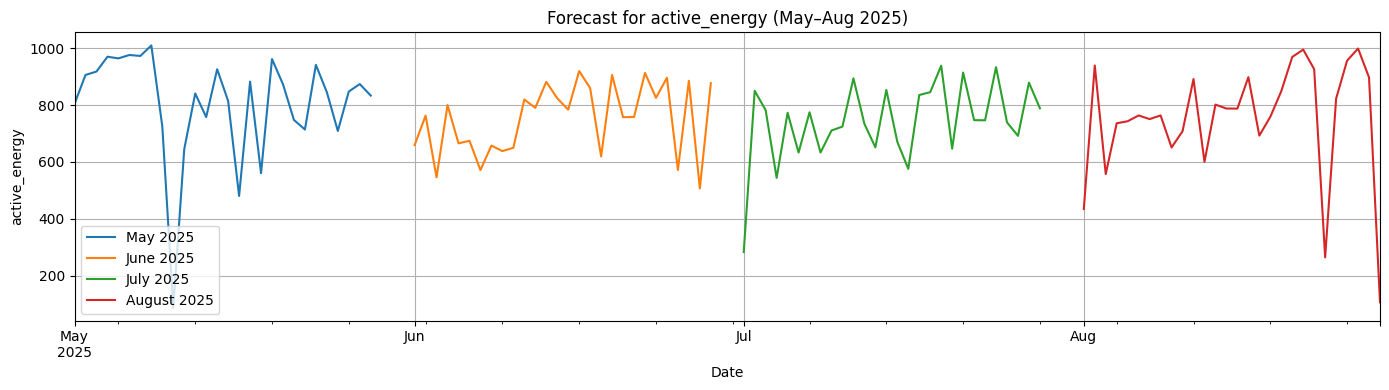

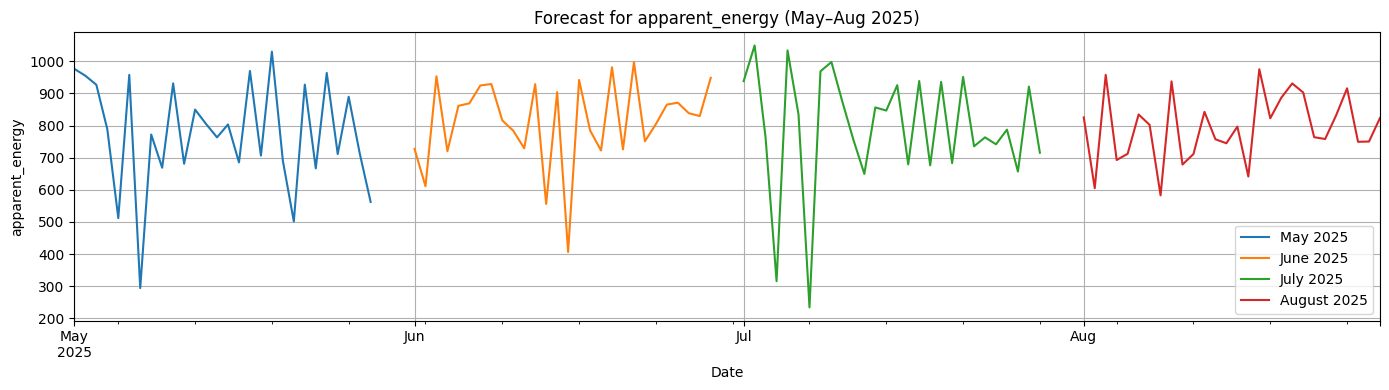

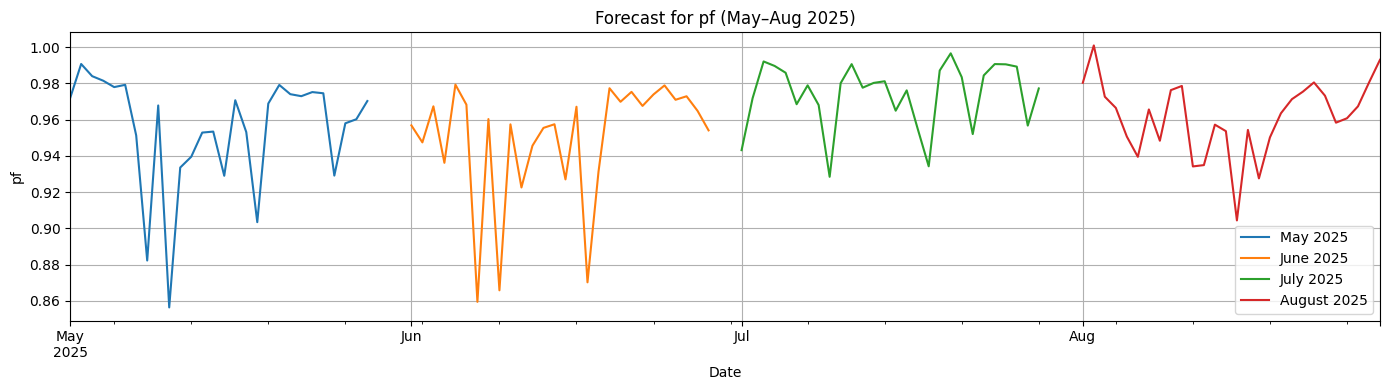

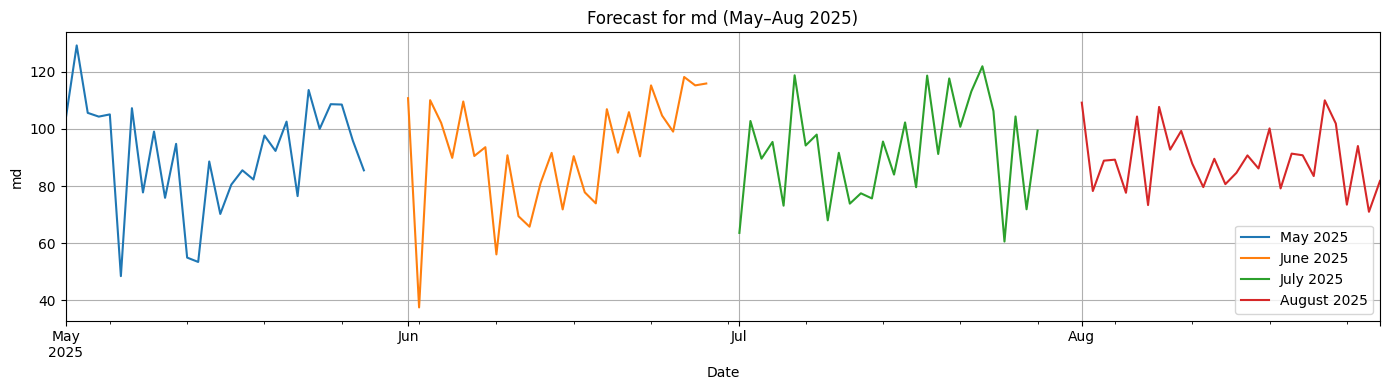

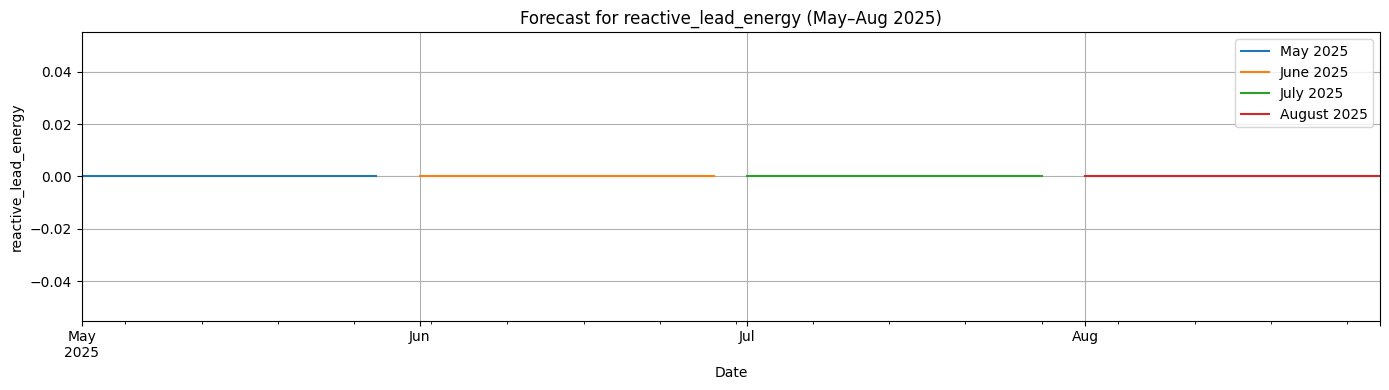

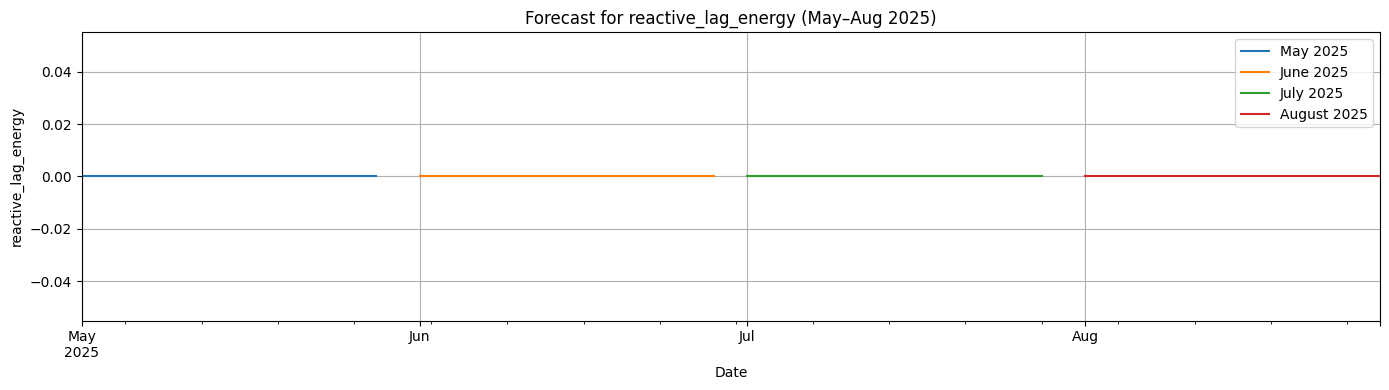

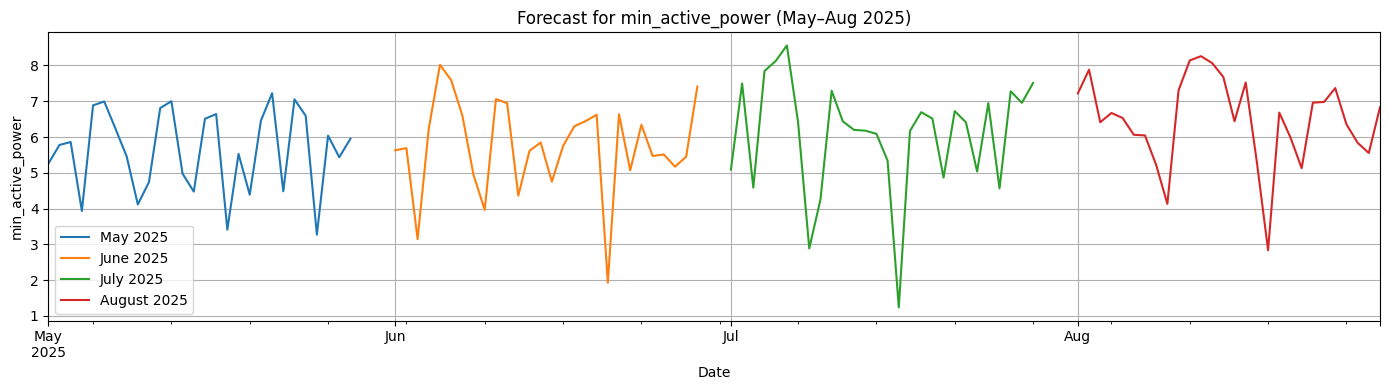

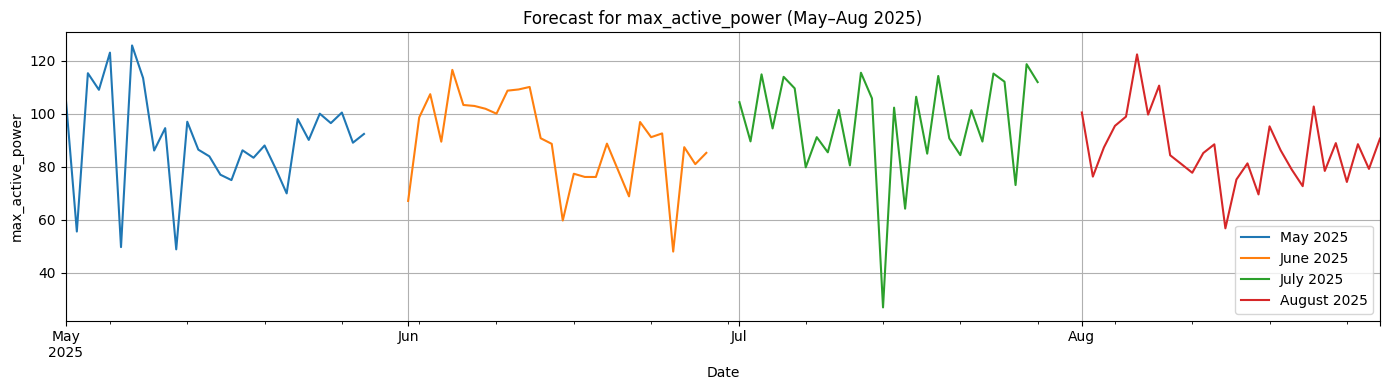

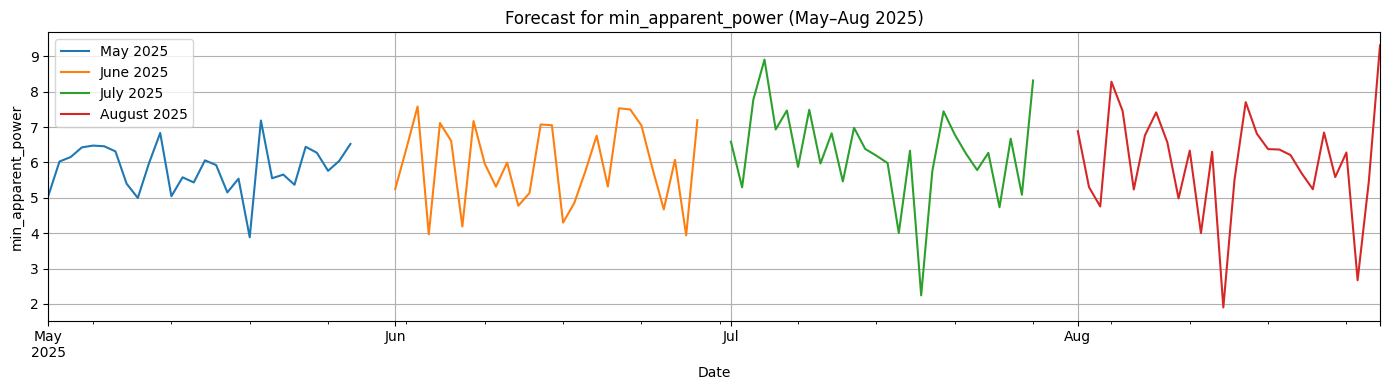

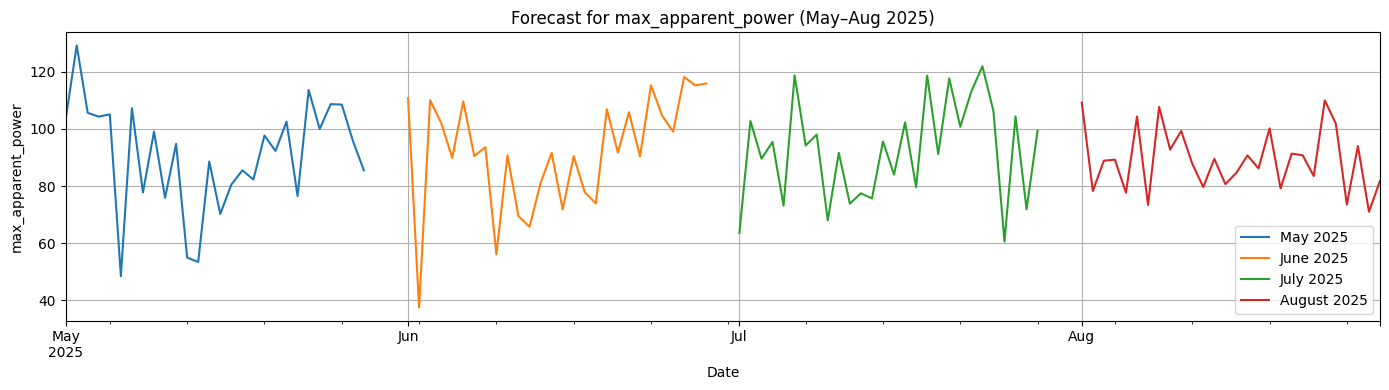

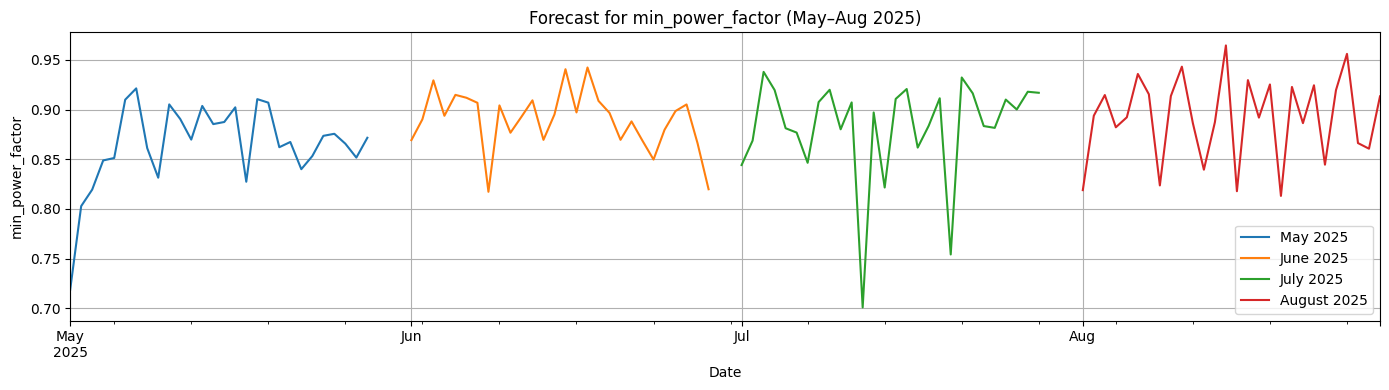

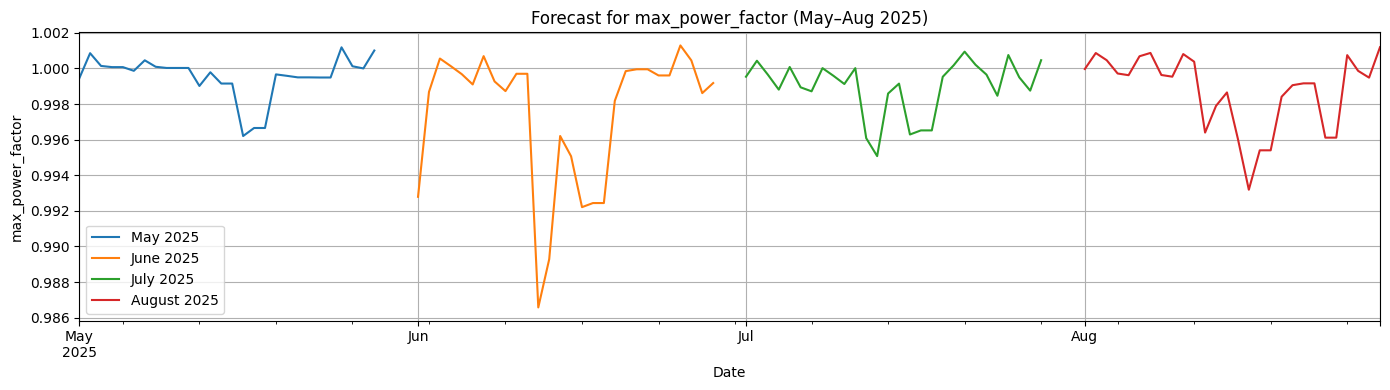

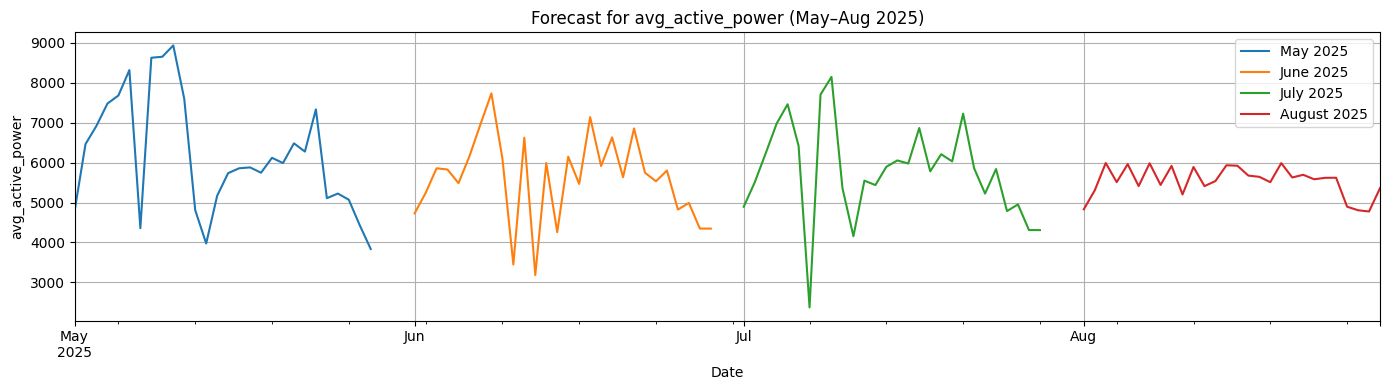

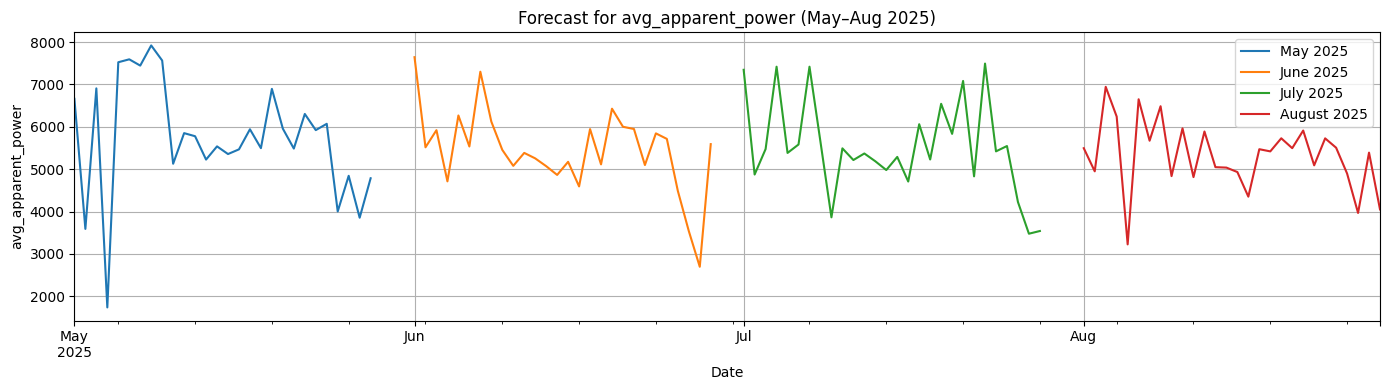

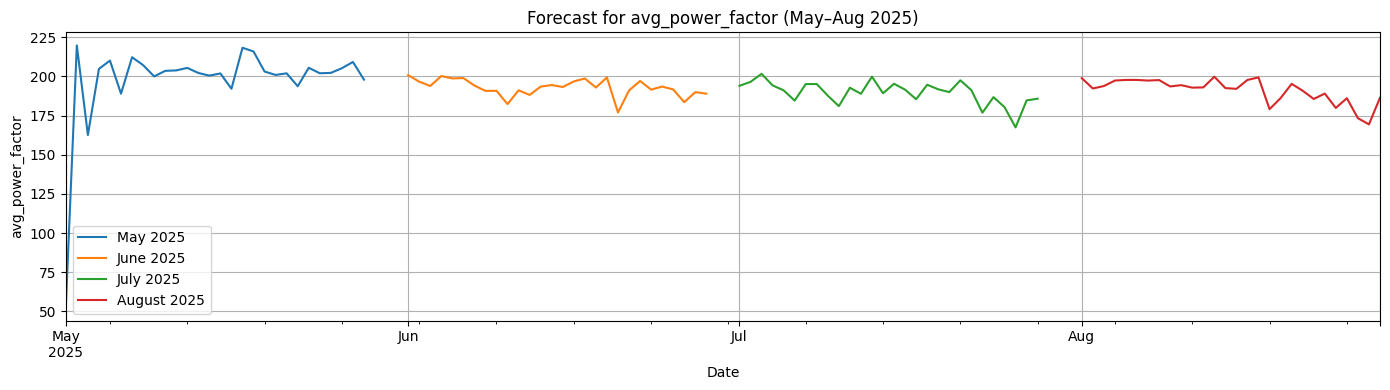

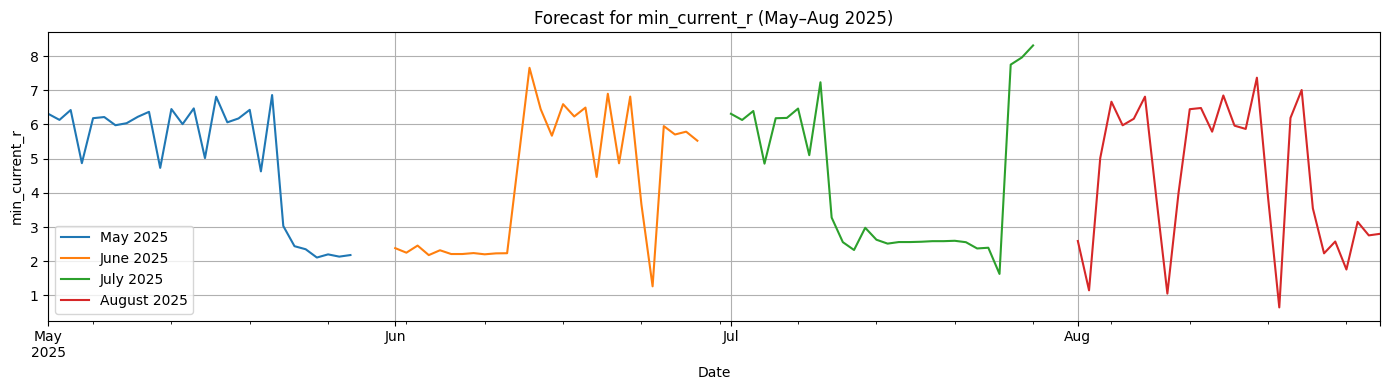

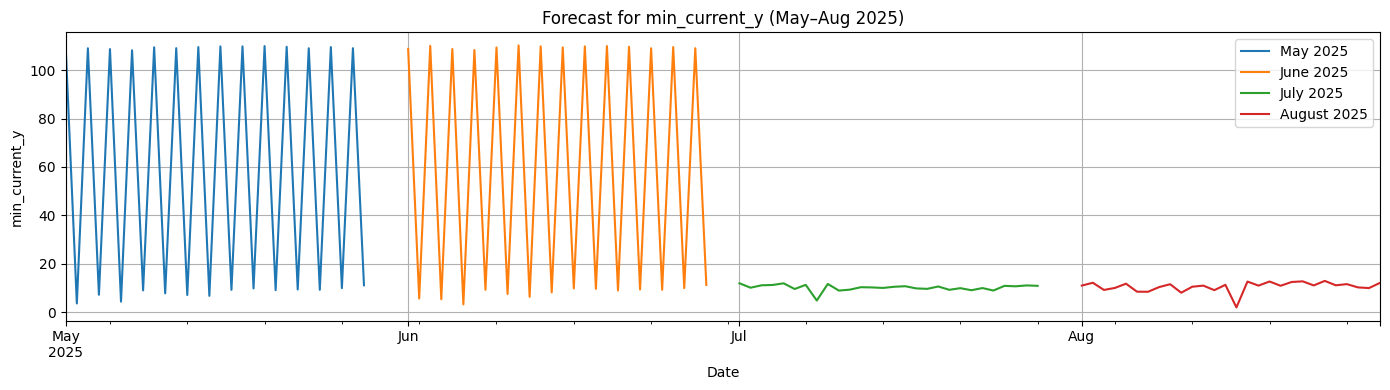

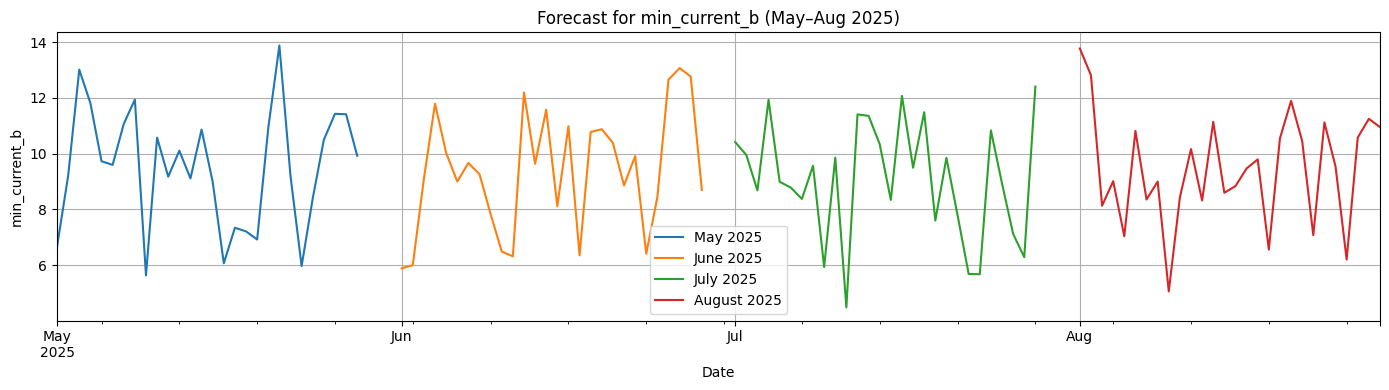

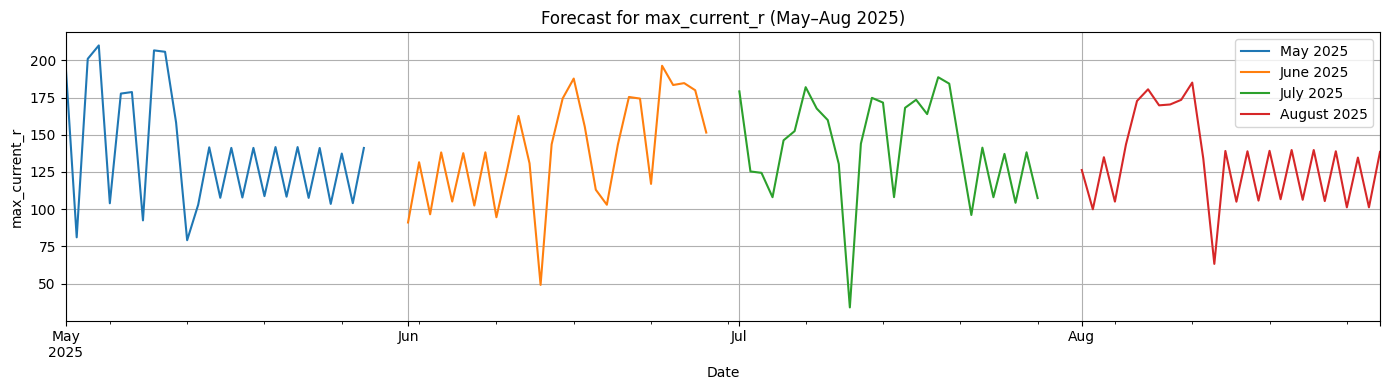

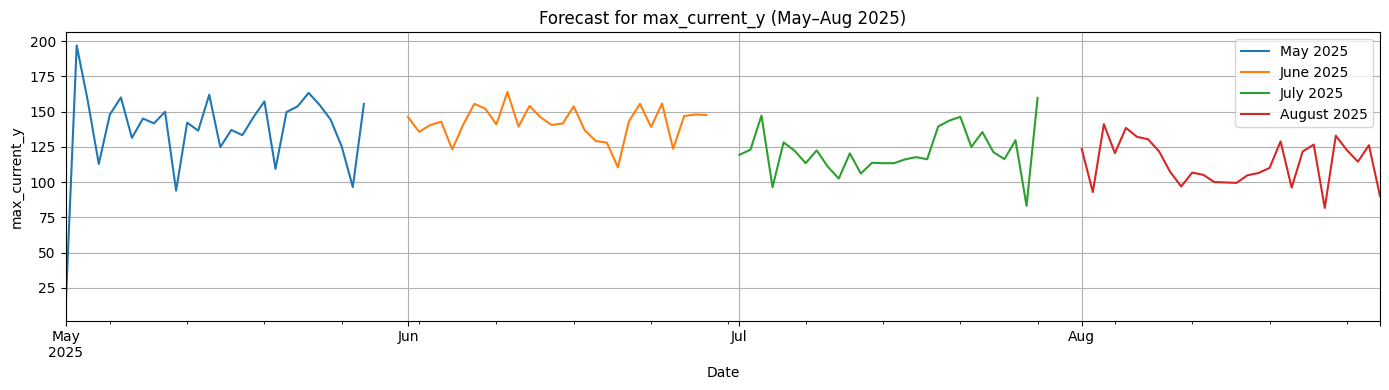

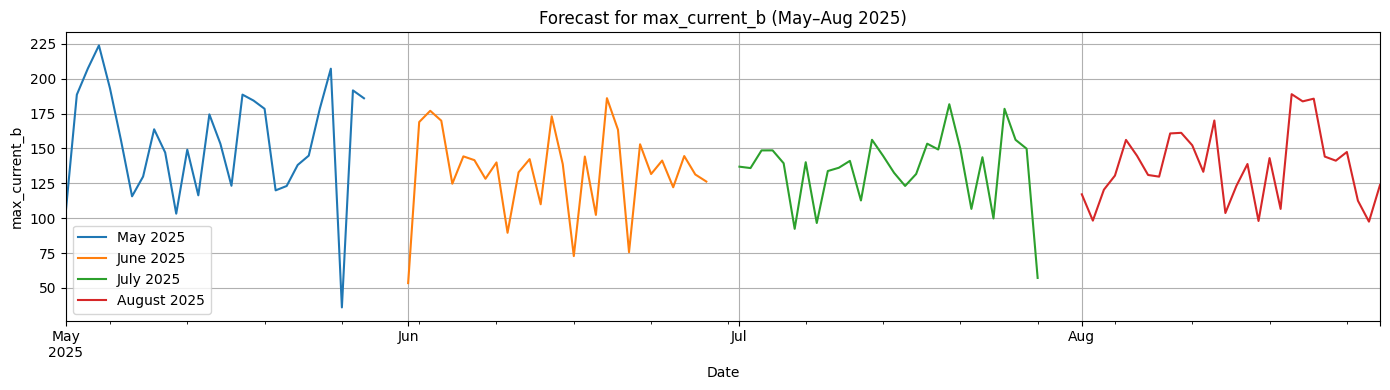

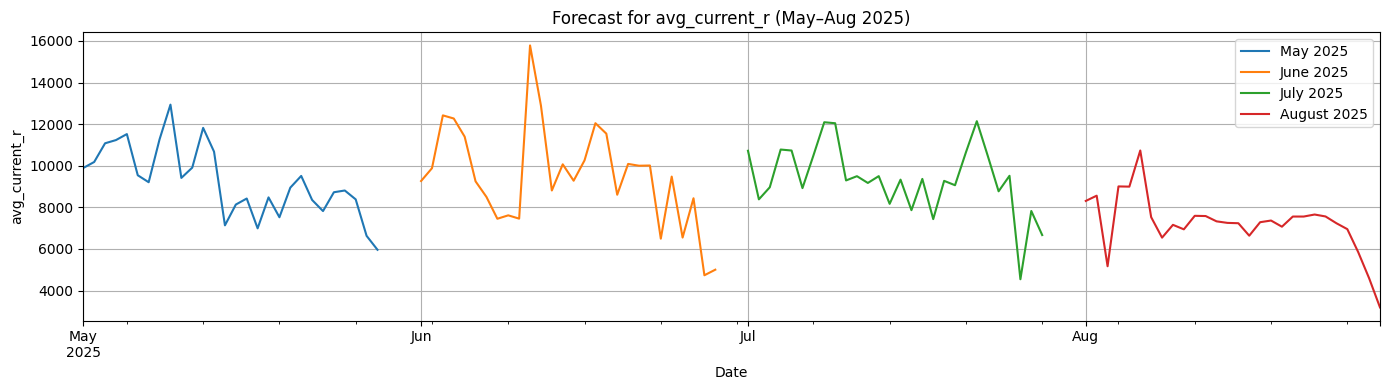

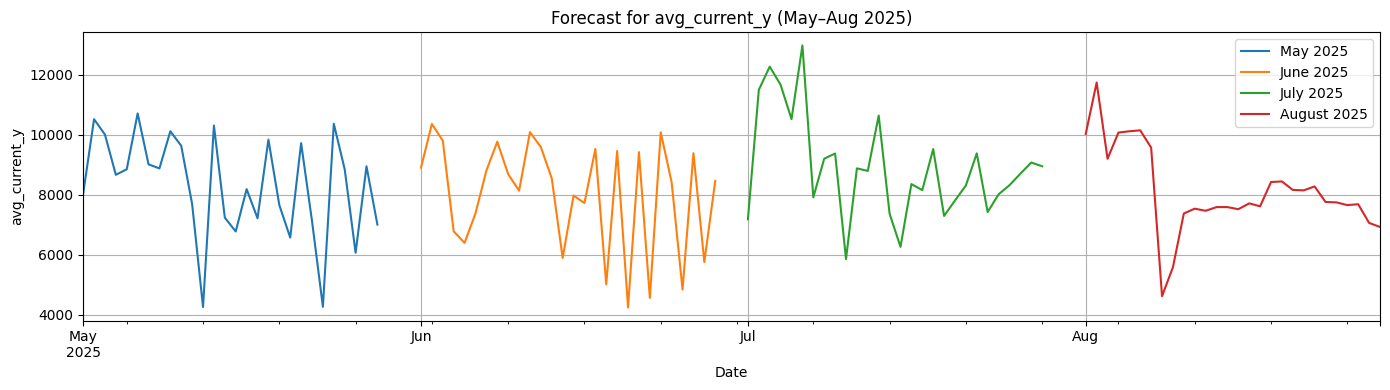

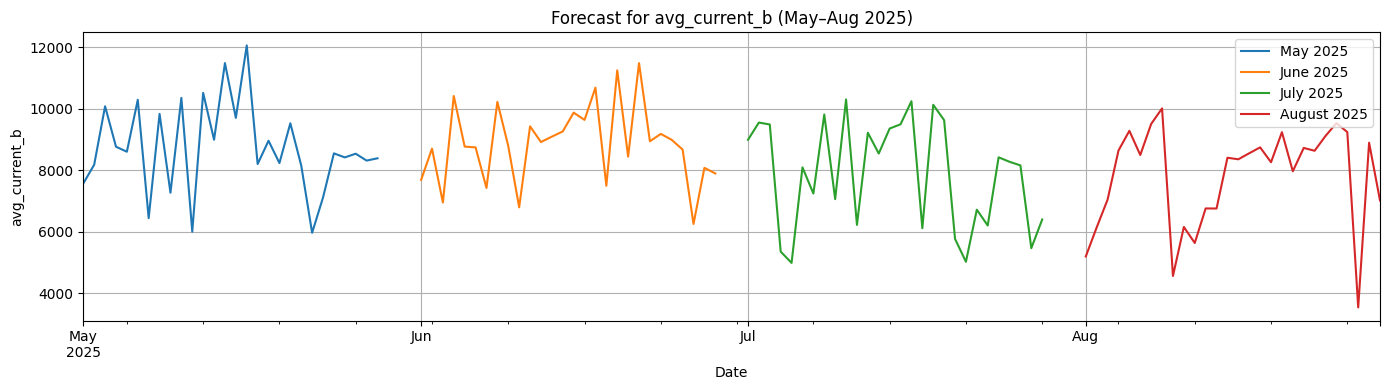

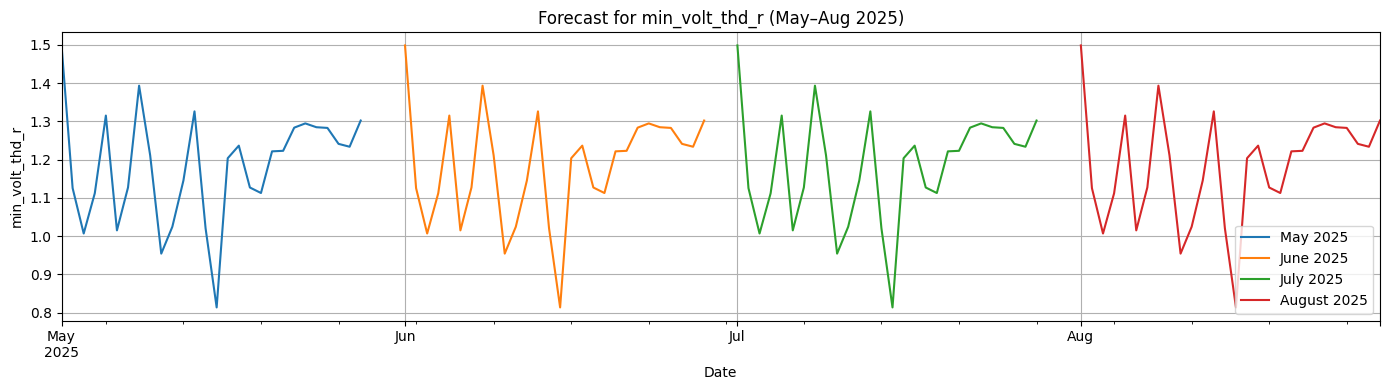

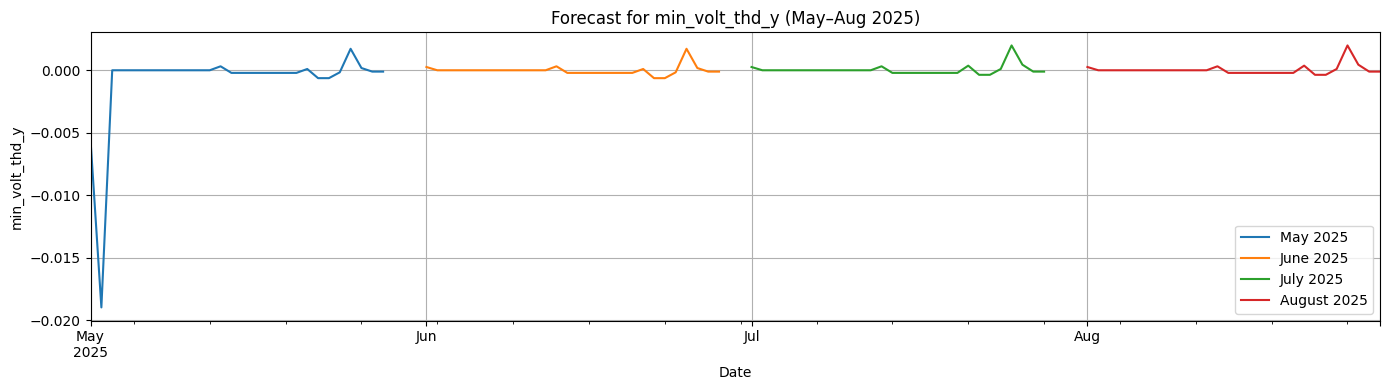

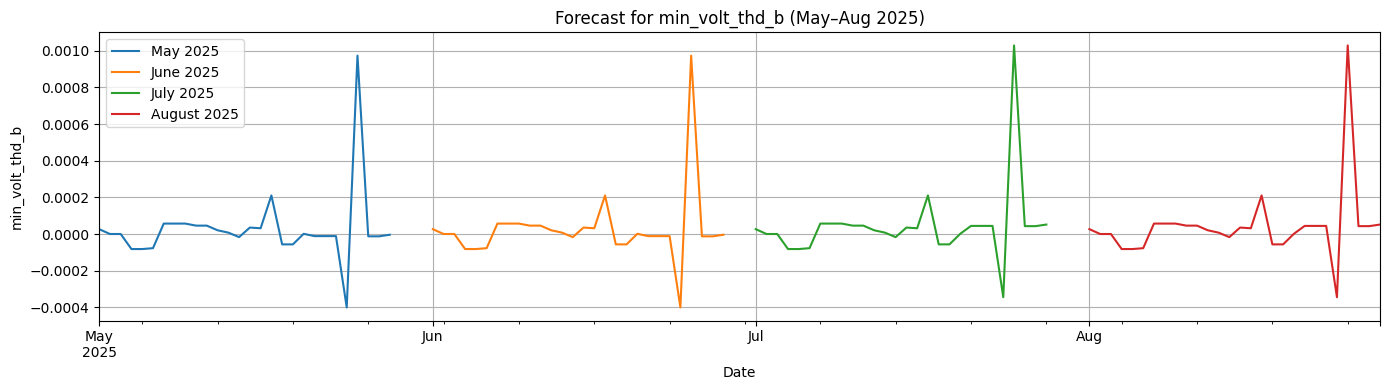

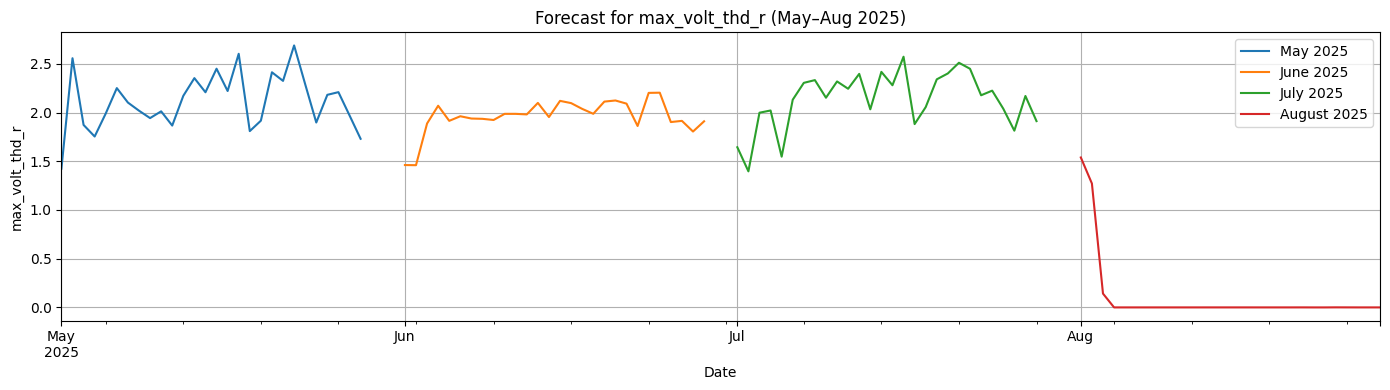

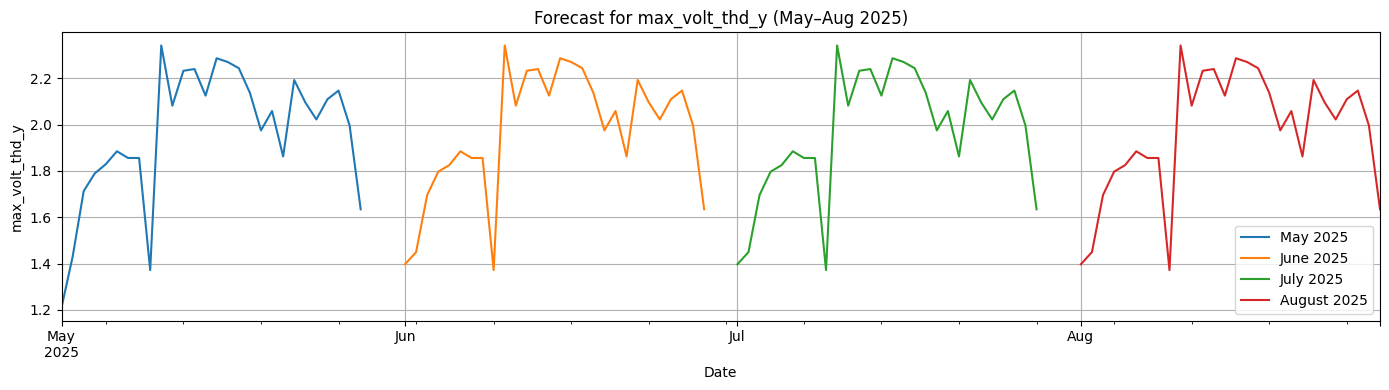

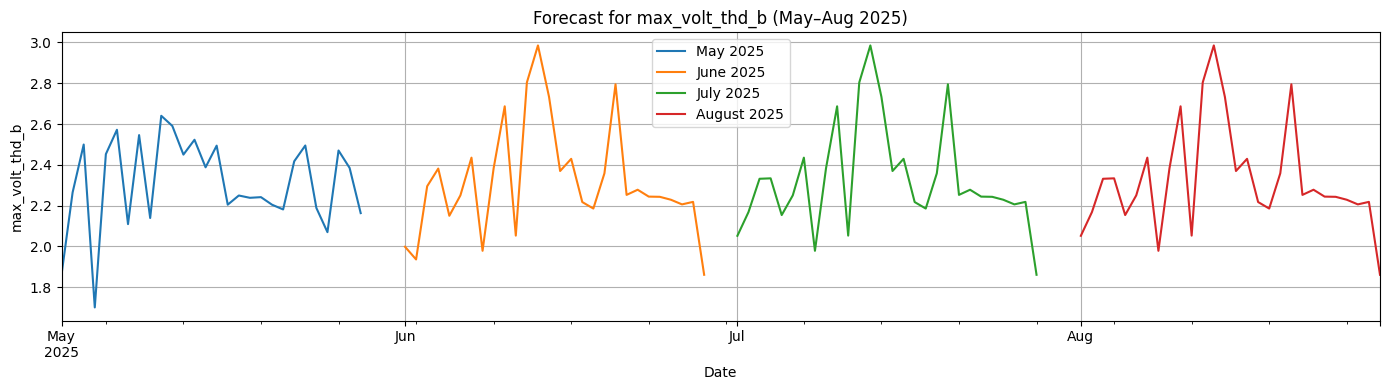

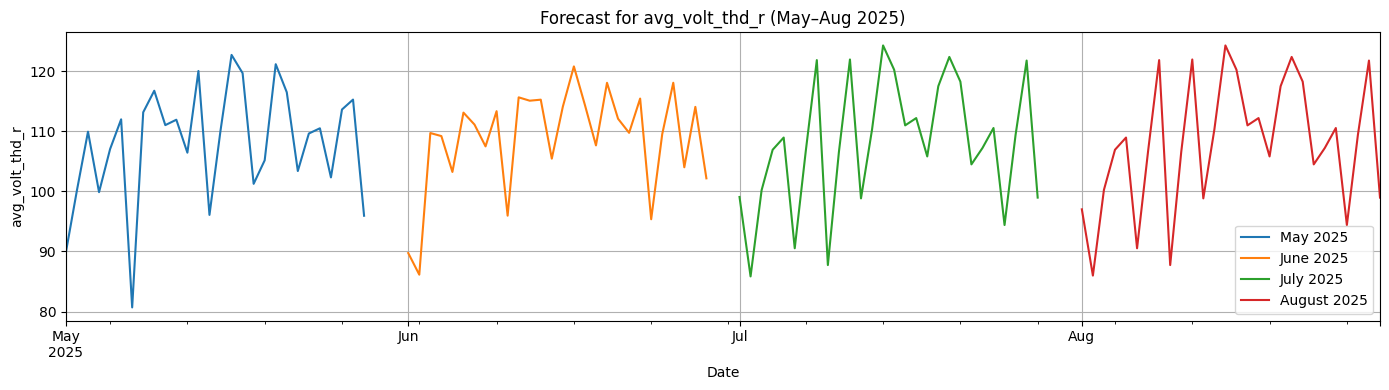

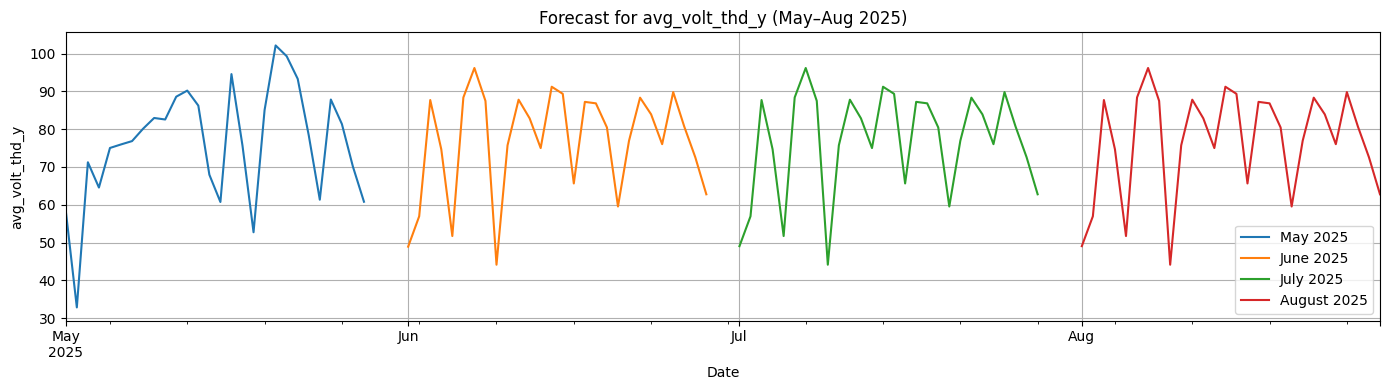

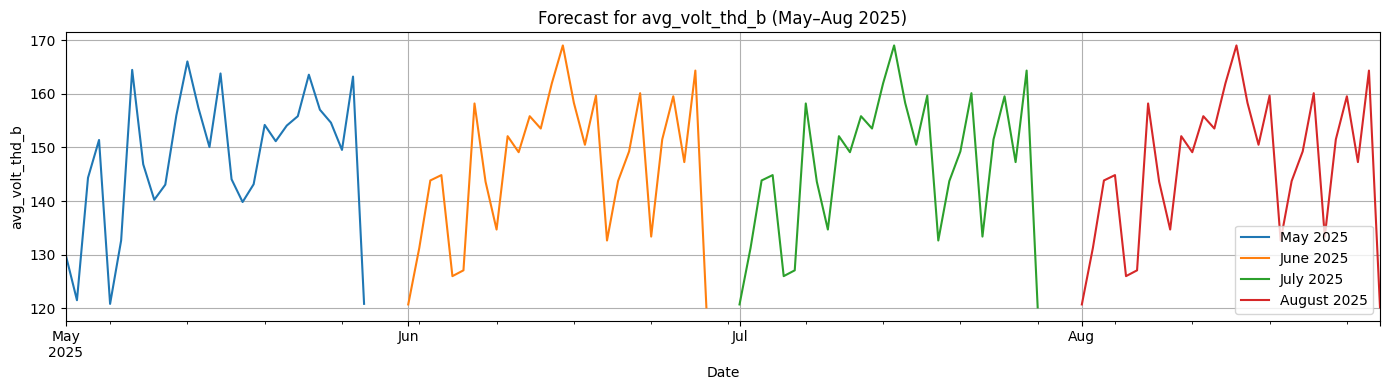

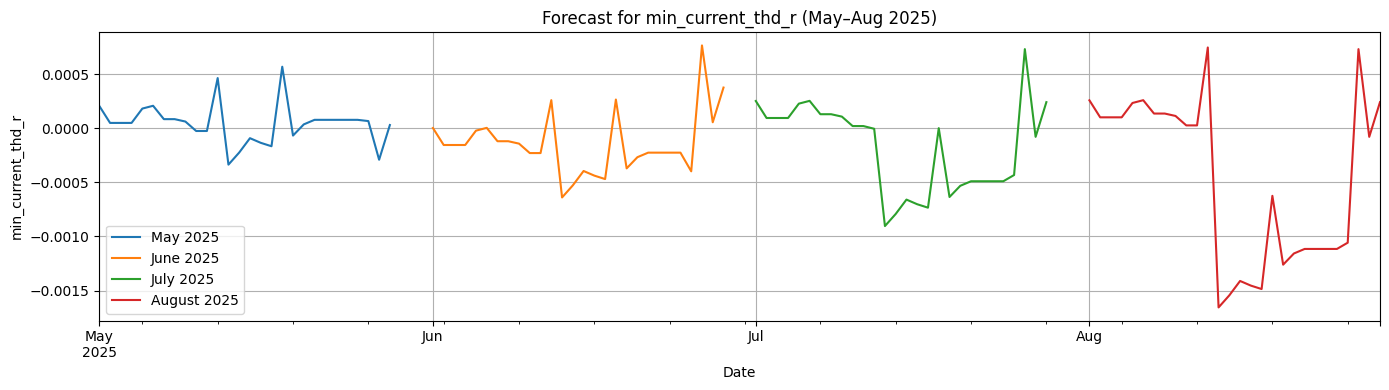

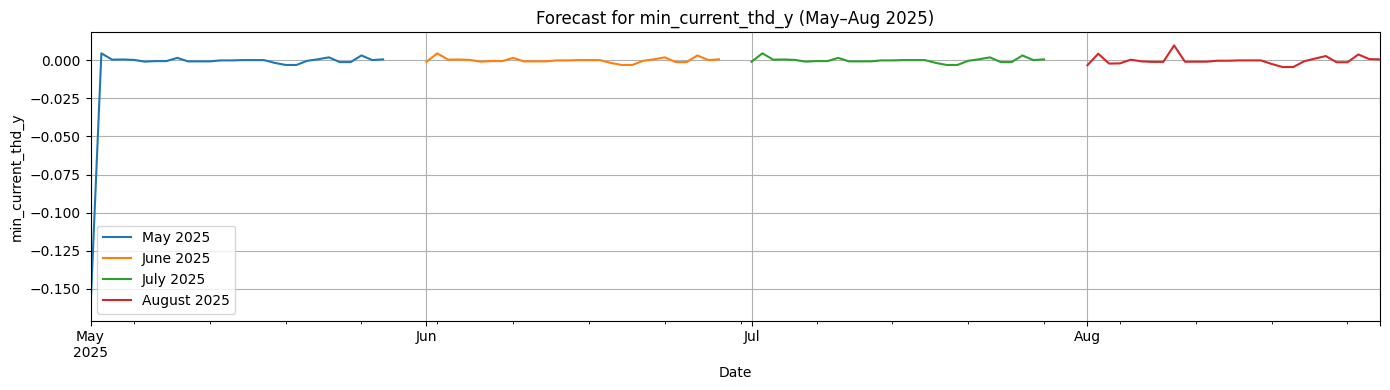

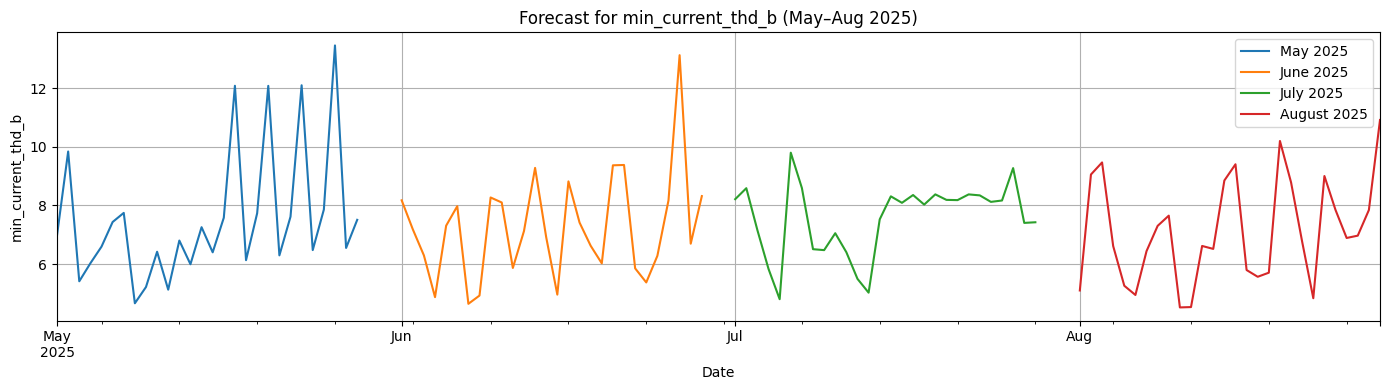

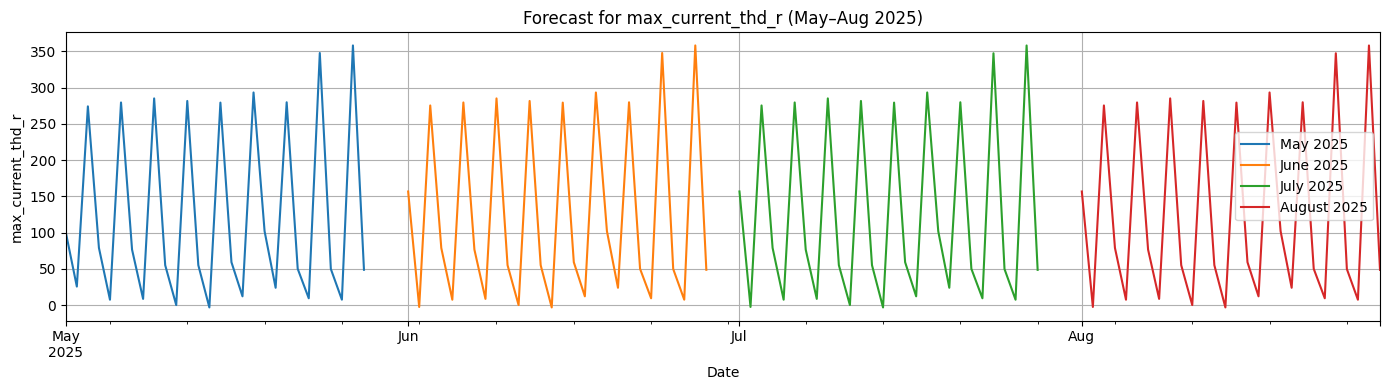

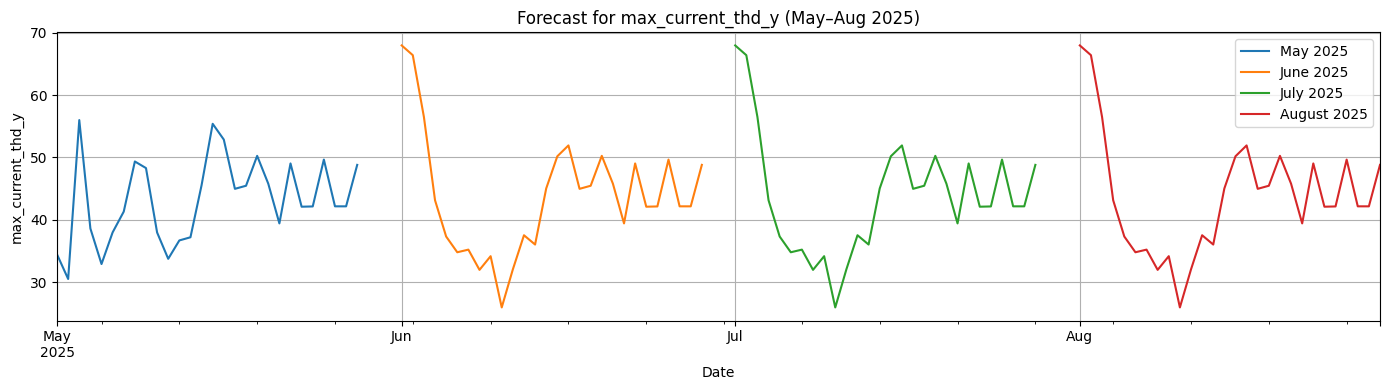

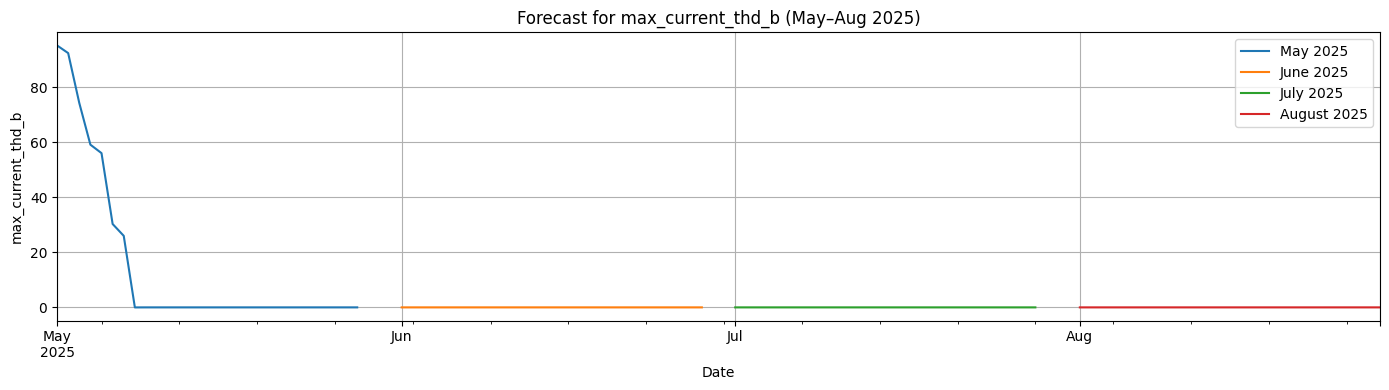

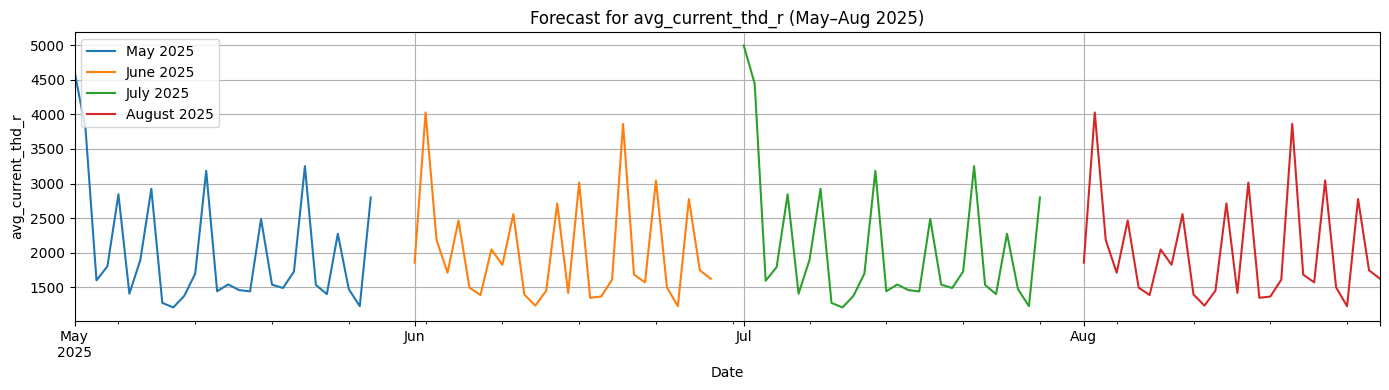

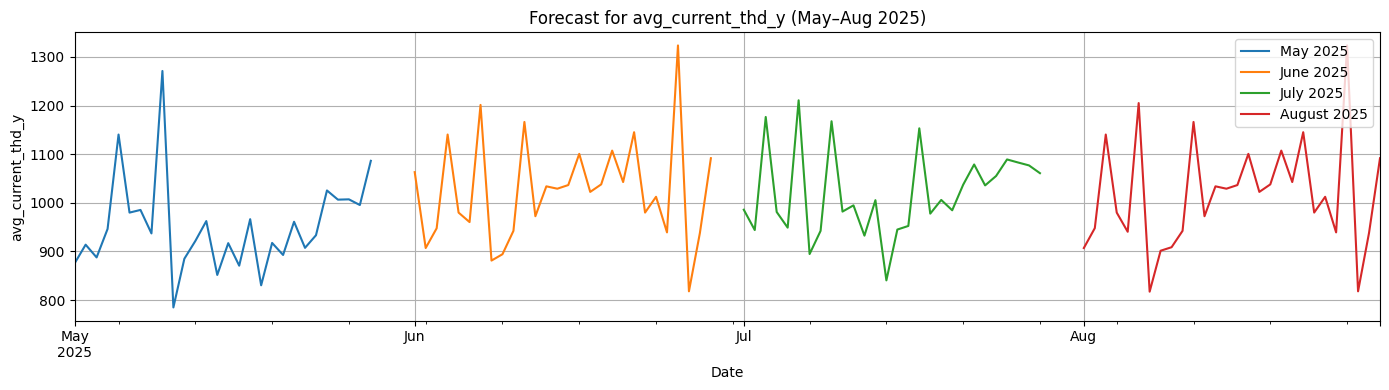

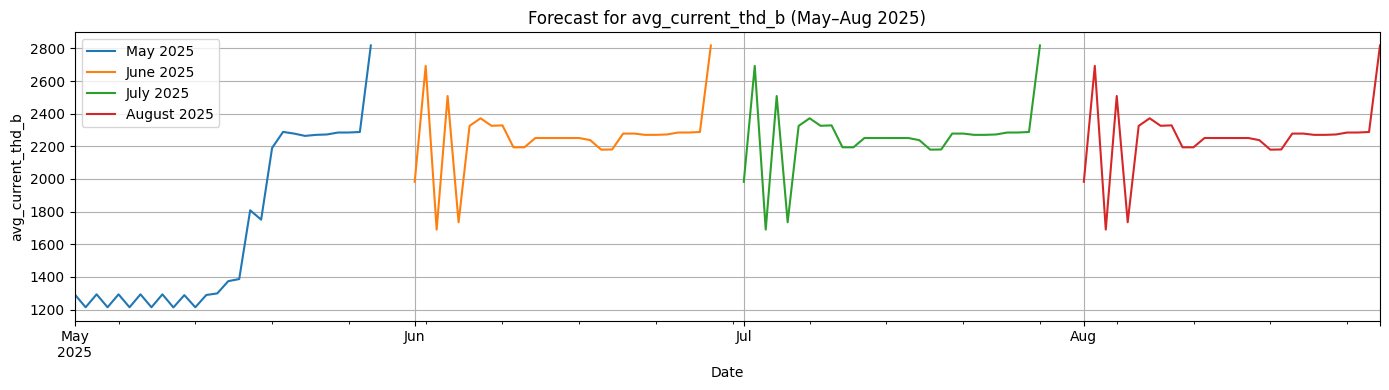

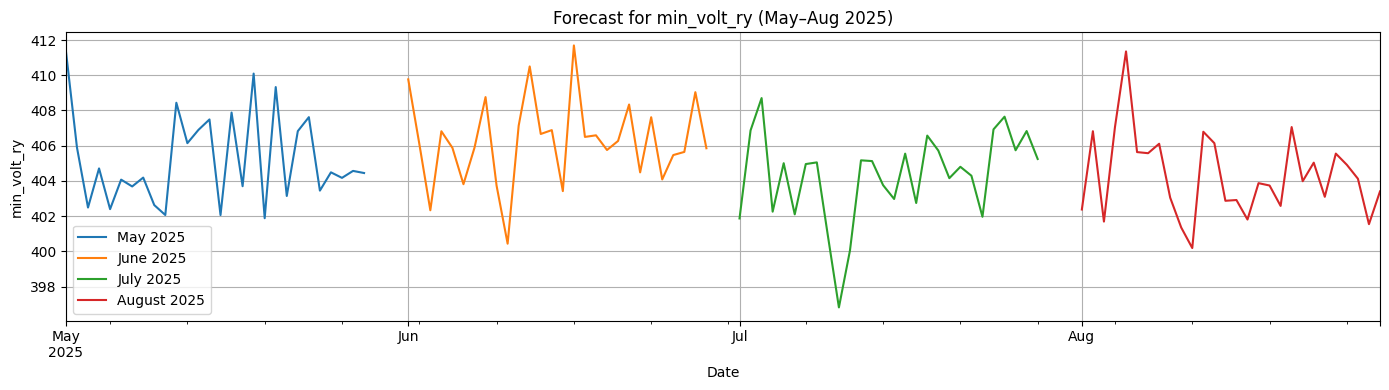

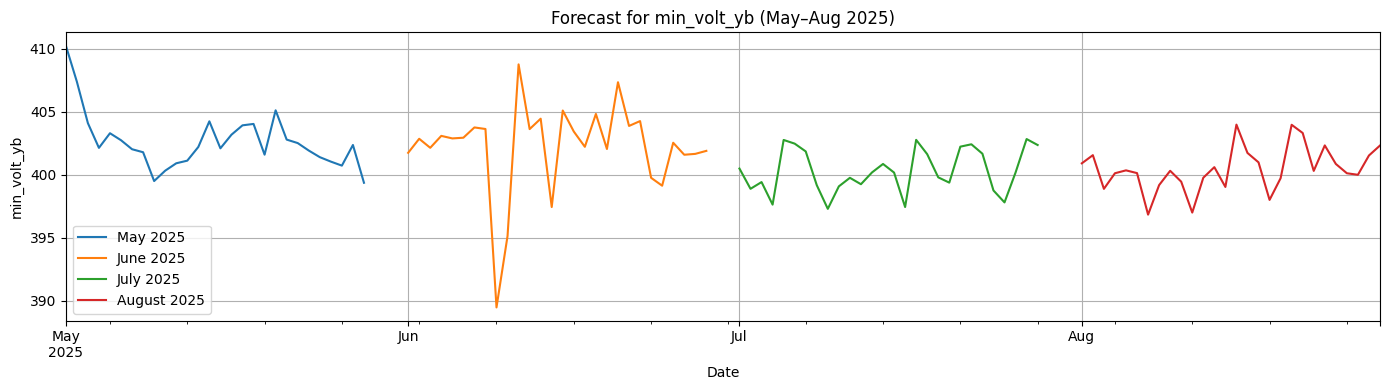

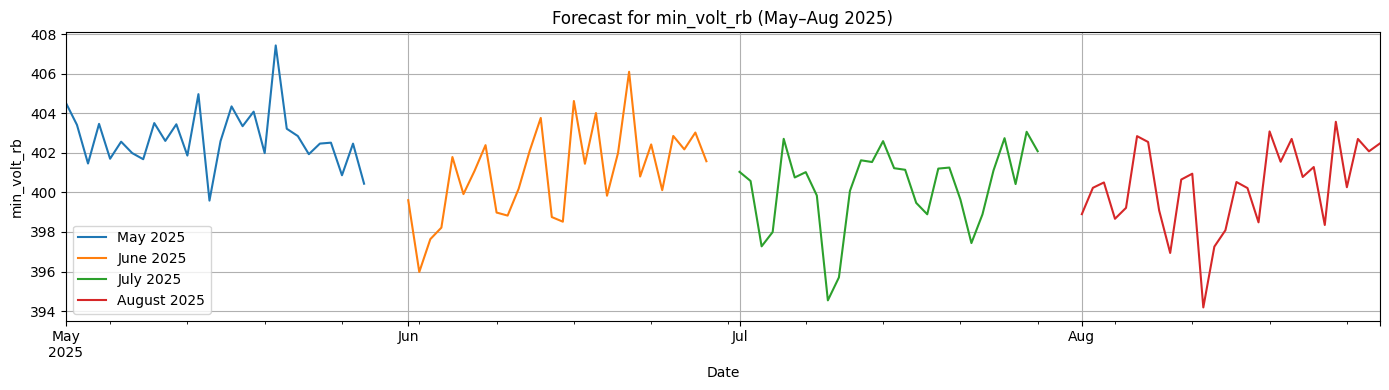

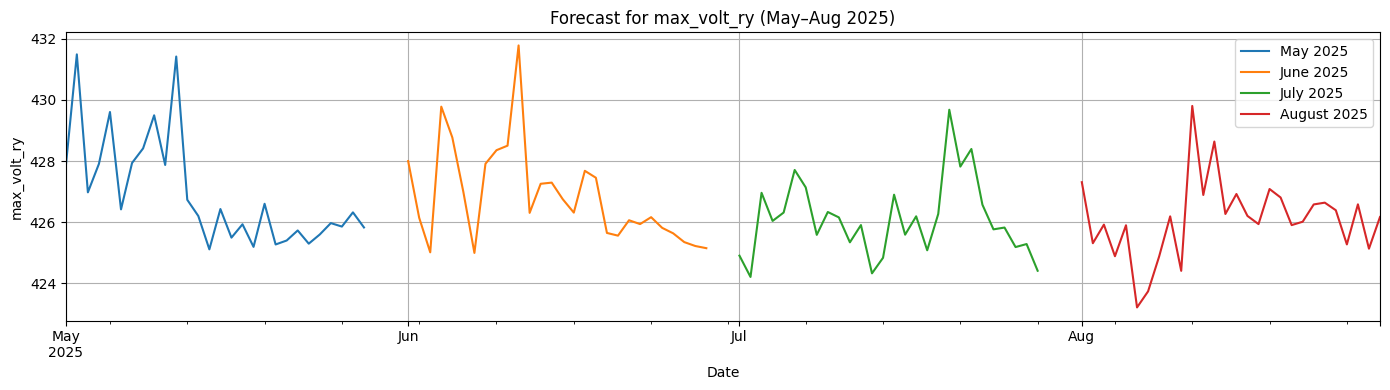

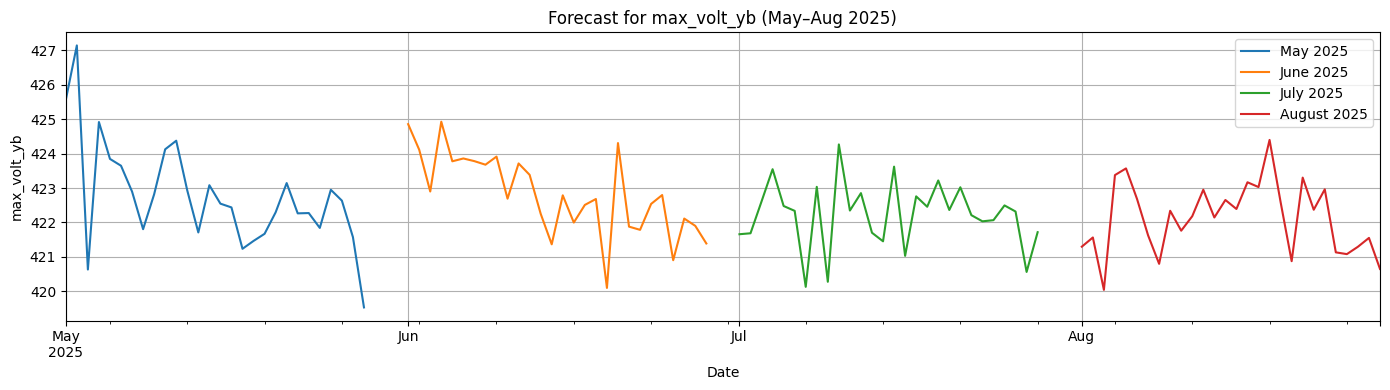

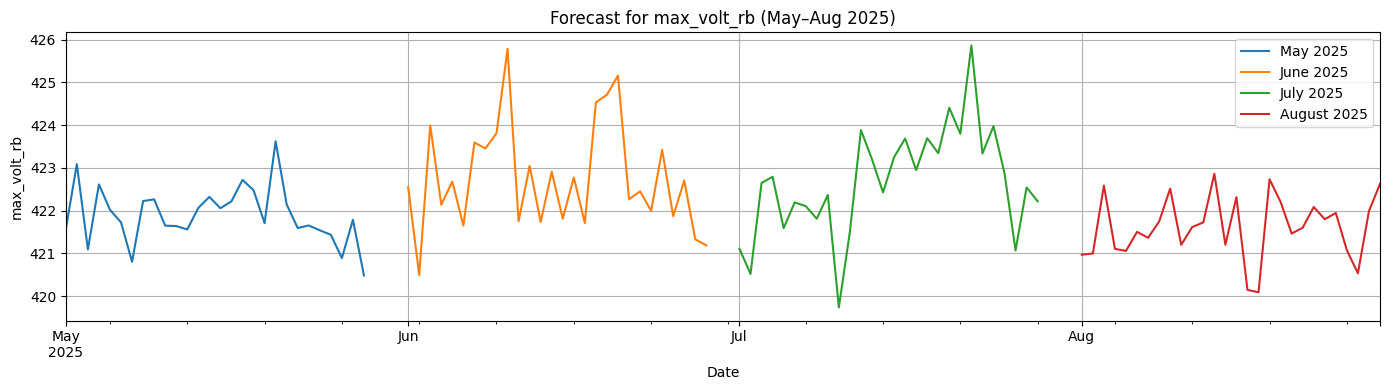

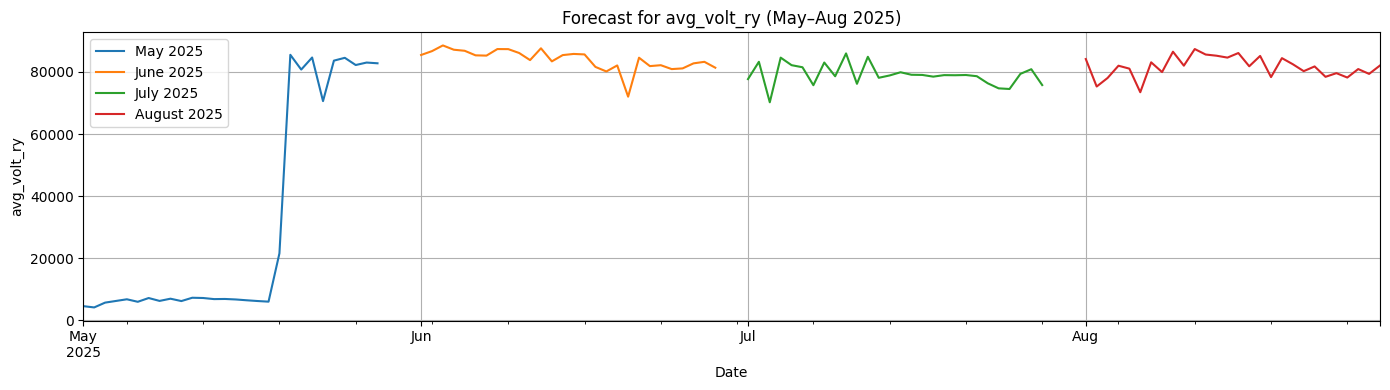

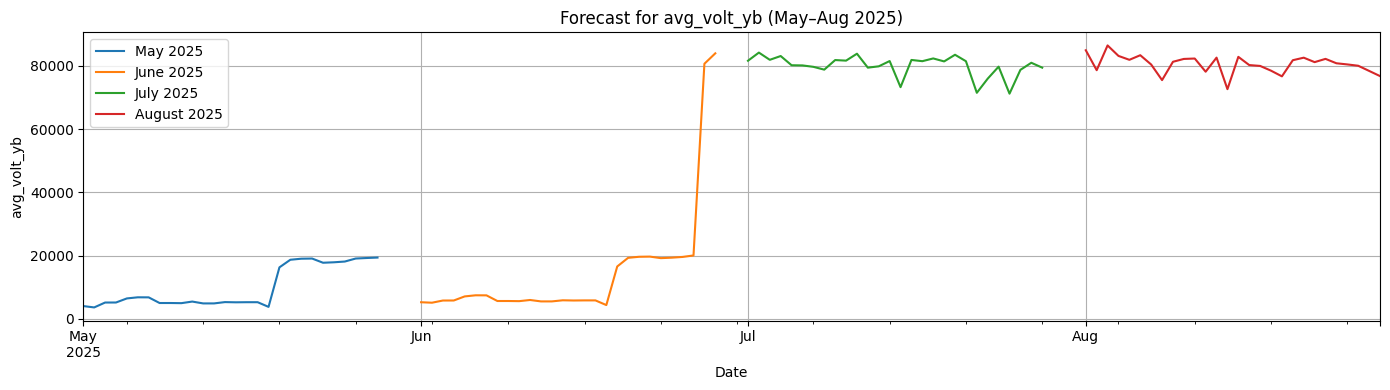

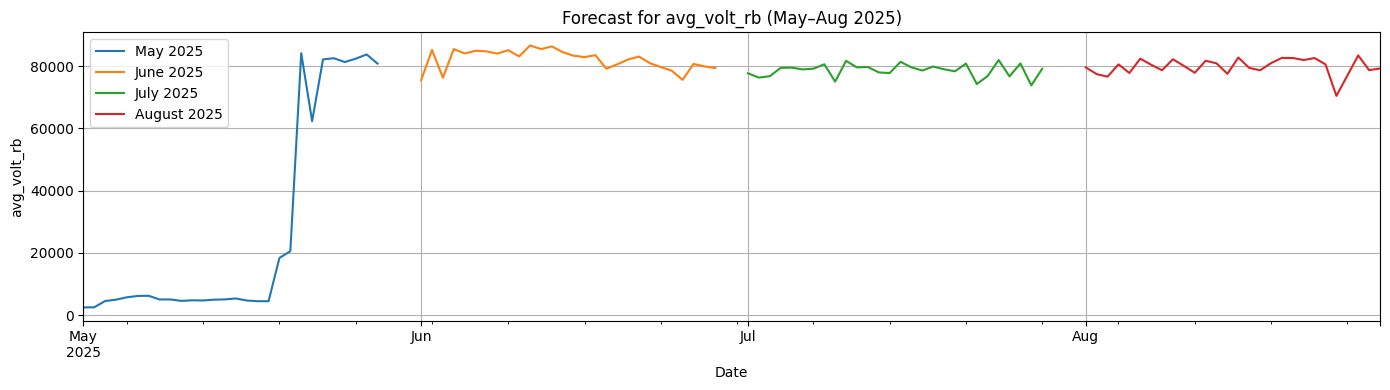

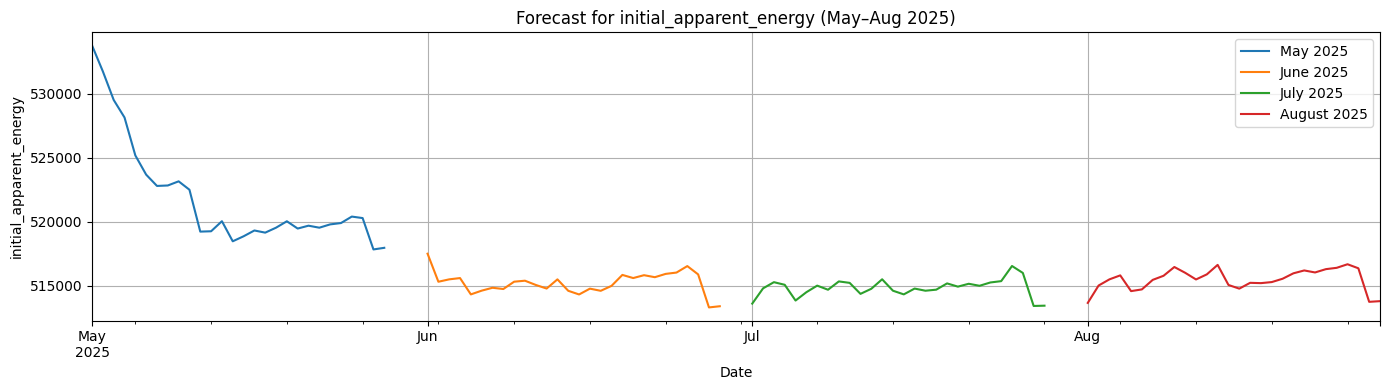

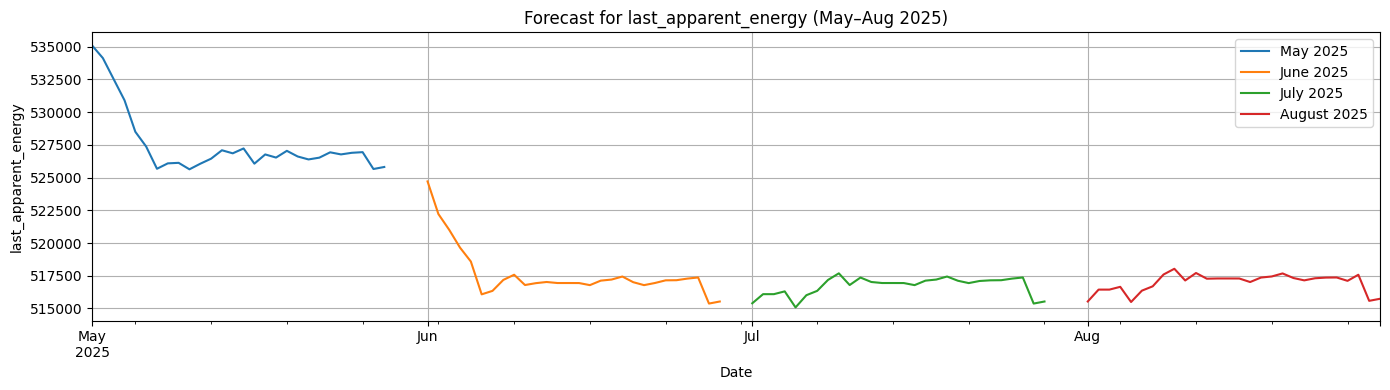

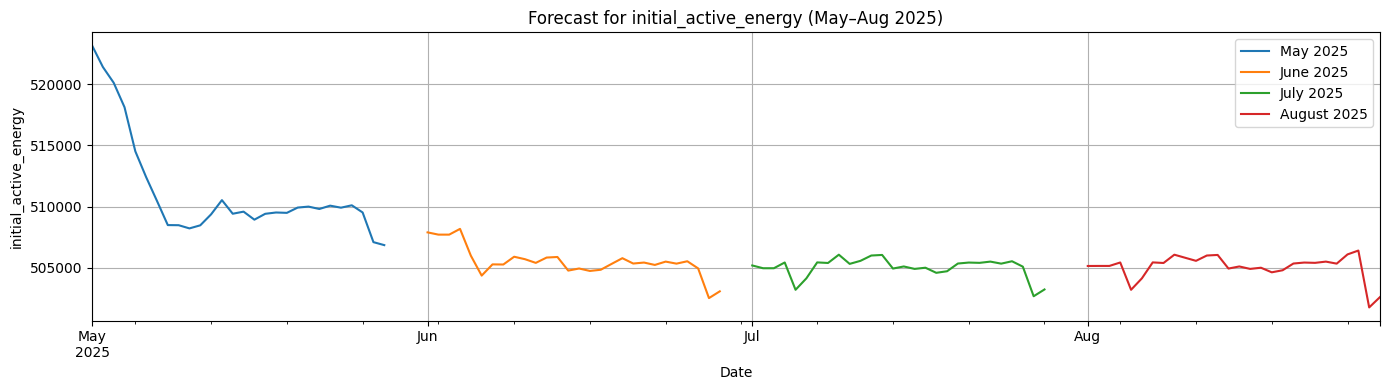

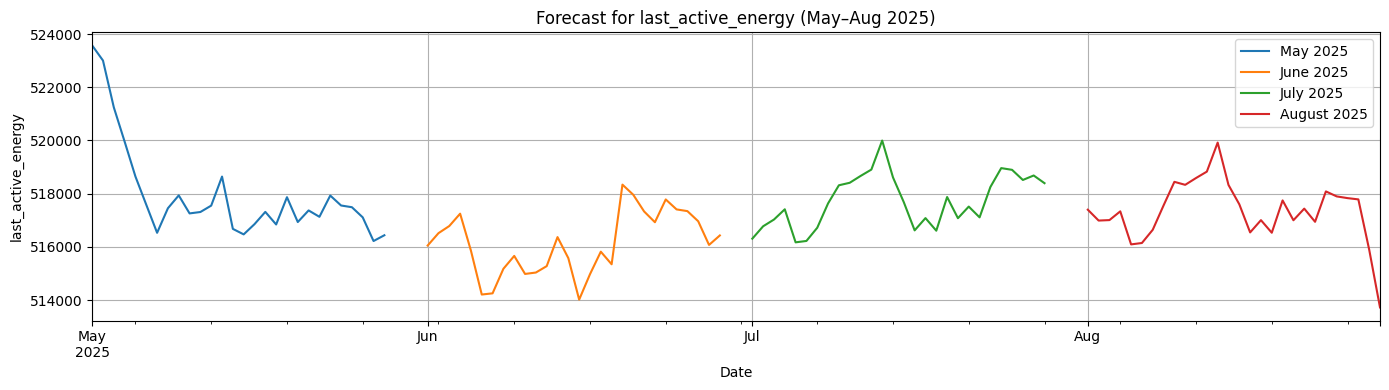

In [12]:
for target in target_columns:
    plt.figure(figsize=(14,4))
    for month in ['May', 'June', 'July', 'August']:
        results[target][month].plot(label=f'{month} 2025')
    plt.title(f'Forecast for {target} (May–Aug 2025)')
    plt.ylabel(target)
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [21]:
final_rows = []

# Define your matching day pairs
for target in target_columns:
    # Get Jan–Apr (before) data
    before_data = df.loc["2025-01-01":"2025-04-30", target]
    before_dates = before_data.index[:len(before_data)]  # dates
    before_values = before_data.values

    # Get May–Aug (after) predictions
    after_data = pd.concat([results[target][m] for m in ['May', 'June', 'July', 'August']])
    after_dates = after_data.index[:len(before_data)]  # align with same count
    after_values = after_data.values

    # Combine each pair
    for bd, ad, bv, av in zip(before_dates, after_dates, before_values, after_values):
        final_rows.append({
            "Date Before Prediction": bd,
            "Date After Prediction": ad,
            "Before Target": target,
            "After Target": target,
            "Before Value": bv,
            "After Value": av,
            "Before Type": "before_prediction",
            "After Type": "after_prediction"
        })

# Create DataFrame
aligned_df = pd.DataFrame(final_rows)

# Save to CSV
aligned_df.to_csv("Aligned_Predictions.csv", index=False)
print("✅ Saved properly aligned comparison as Aligned_Predictions.csv")


✅ Saved properly aligned comparison as Aligned_Predictions.csv
